# MINIST LeNet

Sequential

不计输入层，有3个卷积层，2个下采样（pooling）层，1个全连接层和1个输出层

## 输入包

In [2]:
import os
import tensorflow as tf
import numpy as np
from tensorflow.keras import datasets, layers, models
from PIL import Image
import matplotlib.pyplot as plt
import scipy.misc
np.set_printoptions(suppress=True)

## 定义模型

In [3]:
class LeNet(object):
    def __init__(self):
        model = models.Sequential()
        # 第1层卷积，卷积核大小为3*3，32个，28*28为待训练图片的大小
        model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
        model.add(layers.MaxPooling2D((2, 2)))
        # 第2层卷积，卷积核大小为3*3，64个
        model.add(layers.Conv2D(64, (3, 3), activation='relu'))
        model.add(layers.MaxPooling2D((2, 2)))
        # 第3层卷积，卷积核大小为3*3，64个
        model.add(layers.Conv2D(64, (3, 3), activation='relu'))
        
        # Flatten层用来将输入“压平”，即把多维的输入一维化，常用在从卷积层到全连接层的过渡。Flatten不影响batch的大小。
        model.add(layers.Flatten())
        
        # 全连接层
        model.add(layers.Dense(64, activation='relu'))
        model.add(layers.Dense(10, activation='softmax'))
        
        # model.summary()输出模型各层的参数状况，打印模型的结构
        model.summary()
        
        self.model = model

## 数据准备

In [4]:
class DataSource(object):
    def __init__(self):
        # minisi存储位置，不存在讲自动下载
        data_path = os.path.abspath(os.path.dirname('__file__')) + '\\dataset_tf2\\minist.npz'
        (train_images, train_labels), (test_images, test_labels) = datasets.mnist.load_data(path=data_path)
        # 6万张训练，1万张测试
        train_images = train_images.reshape((60000, 28, 28, 1))
        test_images = test_images.reshape((10000, 28, 28, 1))
        # 像素值映射到0 - 1之间
        train_images, test_images = train_images/255.0, test_images/255.0
        
        # print(train_images[0], train_labels[0])
        
        self.train_images, self.train_labels = train_images, train_labels
        self.test_images, self.test_labels = test_images, test_labels

## 训练

In [5]:
class Train:
    def __init__(self):
        self.cnn = LeNet()
        self.data = DataSource()

    def train(self):
        check_path = './ckpt/cp-{epoch:04d}.ckpt'
        # period 每隔5epoch保存一次
        save_model_cb = tf.keras.callbacks.ModelCheckpoint(check_path, save_weights_only=True, verbose=1, period=5)

        self.cnn.model.compile(optimizer='adam',
                               loss='sparse_categorical_crossentropy',
                               metrics=['accuracy'])
        self.cnn.model.fit(self.data.train_images, self.data.train_labels, epochs=5, callbacks=[save_model_cb])

        test_loss, test_acc = self.cnn.model.evaluate(self.data.test_images, self.data.test_labels)
        print("准确率: %.4f，共测试了%d张图片 " % (test_acc, len(self.data.test_labels)))
        print(self.data.test_images[0],self.data.test_labels[0])

In [5]:
app = Train()
app.train()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten (Flatten)            (None, 576)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                3

准确率: 0.9917，共测试了10000张图片 
[[[0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]]

 [[0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]]

 [[0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.     

## 预测

In [6]:
class Predict(object):
    def __init__(self):
        latest = tf.train.latest_checkpoint('./ckpt')
        self.cnn = LeNet()
        # 恢复网络权重
        self.cnn.model.load_weights(latest)

    def predict(self, image_path):
        # 以黑白方式读取图片
        img = Image.open(image_path).convert('L')
        print(img.size)
        img = img.resize((28, 28))
        img_array = img.load()
        print(img.size)
        
        plt.imshow(img)

        flatten_img = np.reshape(img, (28, 28, 1))
        x = np.array([1 - (flatten_img / 255.0)])

        # API refer: https://keras.io/models/model/
        y = self.cnn.model.predict(x)

        # 因为x只传入了一张图片，取y[0]即可
        # np.argmax()取得最大值的下标，即代表的数字
        print(image_path)
        print(y[0])
        print('        -> Predict digit', np.argmax(y[0]))

## 将图片转换为 （28, 28, 1）

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 576)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)               

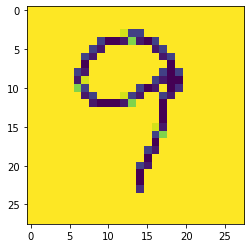

In [7]:
app = Predict()
app.predict('./test_images/test.png')